<a href="https://colab.research.google.com/github/SeungPang11/Data-Mining/blob/main/Locality_Sensitive_Hashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Authors: Jessica Su, Wanzi Zhou, Pratyaksh Sharma, Dylan Liu, Ansh Shukla
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

In [ ]:
# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
# TODO: Implement this
# zip function https://realpython.com/python-zip-function/

def l1(u, v):
    return sum([abs(a-b) for a,b in zip(u,v)])
    #raise NotImplementedError

In [ ]:
# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

with open('drive/MyDrive/Colab Notebooks/patches.csv', 'r') as patches_csv:
  mydata = load_data(patches_csv)


Mounted at /content/drive


In [ ]:
# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

In [ ]:
# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions 
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0, 
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold, 
                                   high = max_threshold + 1, 
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions


In [ ]:
# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

In [ ]:
# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

In [ ]:
# Retrieve all of the points that hash to one of the same buckets 
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

In [ ]:
# Sets up the LSH.  You should try to call this function as few times as 
# possible, since it is expensive.
# A: The dataset.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)


In [ ]:
# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors] #index that refer to patches NN 

In [ ]:
# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_index, num_neighbors):
    #raise NotImplementedError #TODO
    
    #store all the l1 distances from img patches in 100, 200, ... 1000 to all images 
    #EXCLUDING itself
    #then find the 10 nearest neighbors 
    dist_arr = []
   
    for i in range(len(A)):  
      if (i != query_index):
        dist_arr.append(tuple([i, l1(A[query_index], A[i])]))
    
    #sort by distance - index 1
    dist_arr.sort(key=lambda y: y[1])
    
    #return an array of 10 indices of NN/ tuple - l1 distance, index?
    #[t[0] for t in best_neighbors]
    return [t[0] for t in dist_arr[:num_neighbors]]

In [ ]:
#Calculate average search time for lsh and linear finding top 3 NN 
#sum of time / length of time 
import timeit

def avg_search_time(A, f, hsh_A, num_neighbors=3):
  z = np.arange(100,1001,100)

  #10 columns and top 3 NN each 
  lsh_time = []
  
  #print lsh avg search time
  for i in range(10):
    time_diff = 0
      
    for j in range(num_neighbors):
      start_t = timeit.default_timer()
      lsh_arr = lsh_search(A, hsh_A, f, z[i], num_neighbors=3)
    
    stop_t = timeit.default_timer()
    time_diff = stop_t - start_t
    lsh_time.append(time_diff)

  avg_t = sum(lsh_time) / len(lsh_time)

  print("LSH average time: "+ str(avg_t))

  #print linear avg search time
  linear_time = []
 
  for i in range(10):
    time_diff = 0
      
    for j in range(num_neighbors):
      start_t = timeit.default_timer()
      linear_arr = linear_search(A, z[i], num_neighbors=3)
    
    stop_t = timeit.default_timer()
    time_diff = stop_t - start_t
    linear_time.append(time_diff)

  avg_t = sum(linear_time) / len(linear_time)

  print("Linear average time: "+ str(avg_t))

In [ ]:
# TODO: Write a function that computes the error measure

def compute_error(A, hashed_A, functions, num_neighbors=3):
  #the set of image patches 100-1000(inclusive)
  z = np.arange(100,1001,100)
  
  err_res = 0
  total = 0
  
  #error value 
  for j in range(0,10):
    sum_lsh = 0
    sum_linear = 0
    
    lsh_top3 = lsh_search(A, hashed_A, functions, z[j], num_neighbors=3) #LSH array of 3 indices
    linear_top3 = linear_search(A, z[j], num_neighbors=3) #linear array of 3 indices
    
    for i in range(3): #num_neighbors = 3 
      sum_lsh += l1(A[lsh_top3[i]], A[z[j]]) #get distances z[j] = 100,200,..1000
      sum_linear += l1(A[linear_top3[i]], A[z[j]]) #get distances
    
    total += (sum_lsh/sum_linear)
  
  err_res = total / 10
  
  return err_res

In [ ]:
def plot_error_val(A):
  #Plot 1. xlabel - L / ylabel - L error val
  #Plot 2. xlabel - K / ylabel - K error val
  
  L = np.arange(10,21,2)
  funcL_err = []
  
  #k=24, L=10,12,..,20
  for i in range(10, 21, 2):
    
    #lsh_setup returns LSH functions and hashed data structure.
    f, hsh_A = lsh_setup(A, k=24, L=i) 

    #error value
    err_val = compute_error(A, hsh_A, f, num_neighbors=3)

    funcL_err.append(err_val)
  
  plt.plot(L, funcL_err)
  plt.xlabel("L")
  plt.ylabel("L Error Value")
  plt.show()
  
  K = np.arange(16,25,2) 
  funcK_err = []
  
  #L=10, K=16,18,..,24 
  for i in range(16,25,2):

    #lsh_setup returns LSH functions and hashed data structure.
    f, hsh_A = lsh_setup(A, k=i, L=10) 

    #error value
    err_val = compute_error(A, hsh_A, f, num_neighbors=3)

    funcK_err.append(err_val)
  
  plt.plot(K, funcK_err)
  plt.xlabel("K")
  plt.ylabel("K Error Value")
  plt.show()

In [ ]:
# TODO: Solve Problem 4
#https://stackoverflow.com/questions/36006136/how-to-display-images-in-a-row-with-ipython-display

def problem4():
    #raise NotImplementedError
    f, hsh_A = lsh_setup(mydata, k=24, L=10) 
    lsh_arr = lsh_search(mydata, hsh_A, f, query_index = 100, num_neighbors = 10)
    linear_arr = linear_search(mydata, query_index = 100, num_neighbors = 10)
    
    #Q1. avg search time of LSH and Linear
    avg_search_time(mydata, f, hsh_A, num_neighbors=3)
    
    #Q2. plots error values 
    plot_error_val(mydata)
    
    #Q3. plots and shows images 
    lsh_arr.append(100)
    plot(mydata, lsh_arr, "LSH")
     
    print("Row 1. LSH-last is the img patch in col 100")
    fig = figure()
    for i in range(0, 11):
        a=fig.add_subplot(1,11,i+1)
        image = imread("LSH-"+str(lsh_arr[i])+".png")
        imshow(image,cmap='Greys_r')
        axis('off')

    linear_arr.append(100)
    plot(mydata, linear_arr, "Linear")

    print("Row 2. Linear-last is the img patch in col 100")
    fig = figure()
    for i in range(0, 11):
        a=fig.add_subplot(1,11,i+1)
        image = imread("Linear-"+str(linear_arr[i])+".png")
        imshow(image)
        axis('off')

In [ ]:
# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        img = base_filename + "-" + str(row_num) + ".png"
        im.save(img)

In [ ]:
#### TESTS #####
class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

In [ ]:
    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(hash_data(functions, A), np.array([[6, 14], [15, 77]])))

Row 1. LSH-last is the img patch in col 100
Row 2. Linear-last is the img patch in col 100


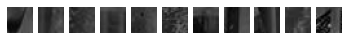

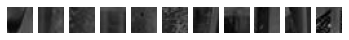

In [ ]:
if __name__ == '__main__':
    #unittest.main() 
    problem4()

In [ ]:
### TODO: Write your tests here (they won't be graded, 
    ### but you may find them helpful)

    #error_val = compute_error(mydata, ha, f, num_neighbors=3)
    #print(error_val)
    #image = Image.open("LSH-"+str(lsh_arr[0])+".png")
    #image.show()
    
    #img = PIL.Image.open("LSH-"+str(lsh_arr[0])+".png")
    #plt.imshow(img)

    #img = PIL.Image.open("LSH-"+str(lsh_arr[10])+".png")
    #plt.imshow(img)

In [ ]:
#test
def test_(arr):
    #arr = [(2, 123), (3, 421), (1, 500)]
    arr.sort(key=lambda y: y[1])
    
    return [t[0] for t in arr[:3]]

arr1 = [(2, 123), (3, 421), (1, 500)]
arr2 = test_(arr1)

arr3 = []
#for i in range(10): 
for i in range(3):
  print(i)
